In [283]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

In [284]:
data_files = os.listdir('data')

data_frames = {}
for file in data_files:
    file_path = os.path.join('data', file)
    if file.endswith('.csv'):
        data_frames[file] = pd.read_csv(file_path)

In [285]:
cutoff_time = pd.Timestamp('2024-12-04 03:00:00', tz='UTC')

for file in data_files:
    if file.endswith('.csv'):
        data_frames[file]['time'] = pd.to_datetime(data_frames[file]['time']).dt.floor('s')
        data_frames[file] = data_frames[file][data_frames[file]['time'] >= cutoff_time]
        

In [286]:
for file in data_files:
    if file.endswith('.csv') and 'value' in data_frames[file].columns:
        data_frames[file].rename(columns={'value': f'value_{file.split(".")[0]}'}, inplace=True)

In [287]:
on_change_cols = ['IOT_project-minimum_water_threshold.csv', 'IOT_project-need_water.csv', 'IOT_project-led_on.csv', 'IOT_project-minimum_light_threshold.csv']

# Initialize the merged dataframe with the first dataframe in the dictionary
merged_df = data_frames[data_files[0]]
merged_on_change_df = data_frames[on_change_cols[0]]

# Loop through the remaining dataframes and merge them on the 'time' column
for file in data_files[1:]:
    if file.endswith('.csv') and file not in on_change_cols:
        merged_df = pd.merge(merged_df, data_frames[file], on='time', suffixes=('', f'_{file.split(".")[0]}'))
    elif file in on_change_cols and file != on_change_cols[0]:
        merged_on_change_df = pd.merge(merged_on_change_df, data_frames[file], on='time', how='outer', suffixes=('', f'_{file.split(".")[0]}'))

print(merged_df.shape)
print(merged_on_change_df.shape)

(66457, 10)
(73474, 5)


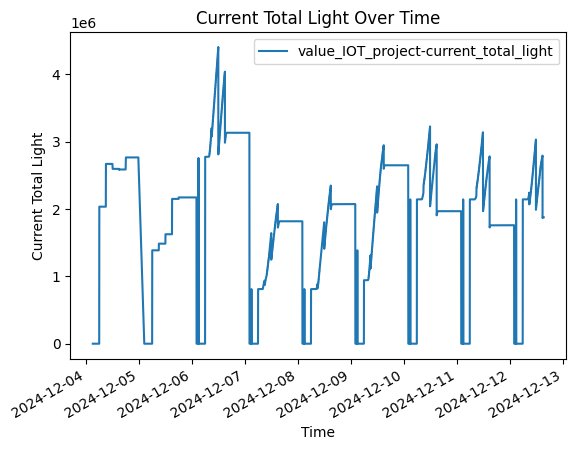

In [288]:
merged_df.plot(x='time', y='value_IOT_project-current_total_light', kind='line')
plt.xlabel('Time')
plt.ylabel('Current Total Light')
plt.title('Current Total Light Over Time')
plt.show()

In [289]:
print("Non-continous data:")
print(merged_on_change_df.isnull().sum())
print("\nContinous data:")
print(merged_df.isnull().sum())

Non-continous data:
time                                             0
value_IOT_project-minimum_water_threshold    73432
value_IOT_project-minimum_light_threshold      374
value_IOT_project-need_water                 73142
value_IOT_project-led_on                     73427
dtype: int64

Continous data:
time                                     0
value_IOT_project-internal_hum           0
value_IOT_project-current_total_light    0
value_IOT_project-total_light            0
value_IOT_project-outdoor_hum            0
value_IOT_project-light_value            0
value_IOT_project-outdoor_temp           0
value_IOT_project-predicted_light        0
value_IOT_project-internal_temp          0
value_IOT_project-soil_moisture          0
dtype: int64


In [290]:
merged_df_copy = merged_df.copy()

In [291]:
merged_df_copy['day_time'] = np.where((merged_df['time'].dt.hour >= 8) & (merged_df['time'].dt.hour <= 16), 1, 0)

In [292]:
merged_df_copy['day_time'].value_counts()

day_time
0    40142
1    26315
Name: count, dtype: int64

In [293]:
merged_df_copy.drop(columns=['time'], inplace=True)

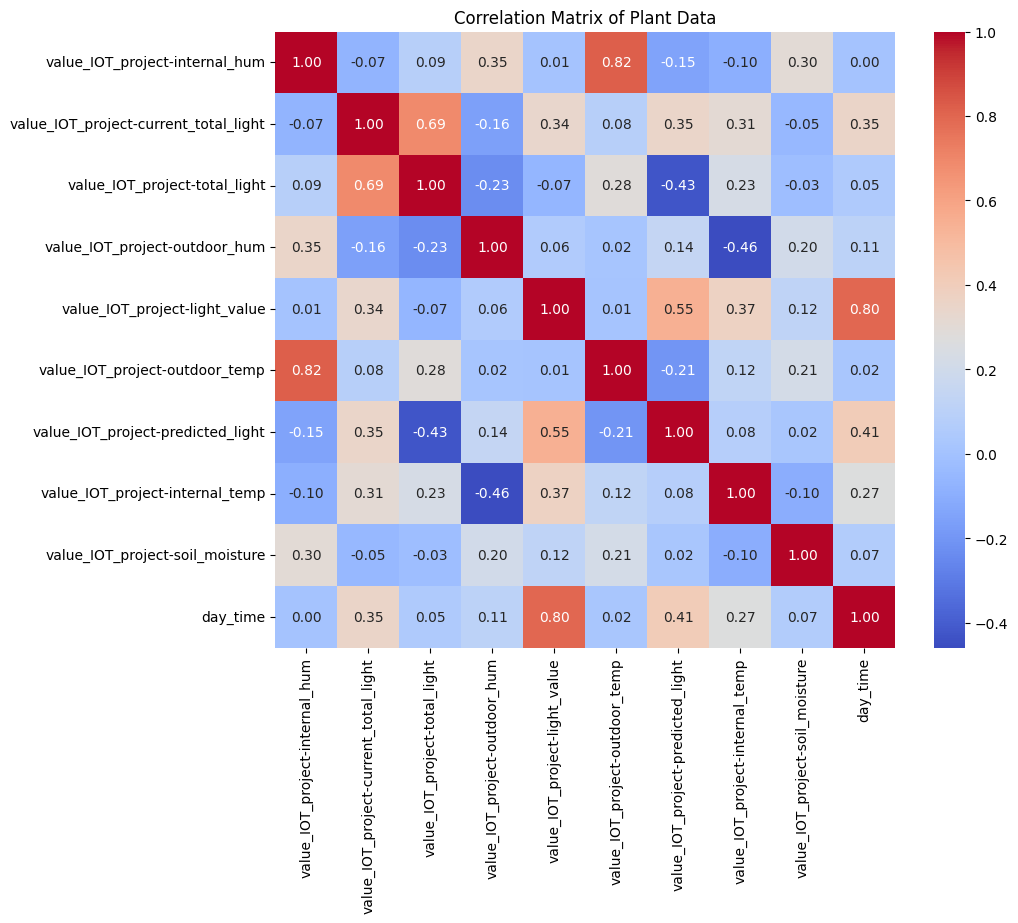

In [294]:
# Compute the correlation matrix
corr_matrix = merged_df_copy.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Plant Data')
plt.show()

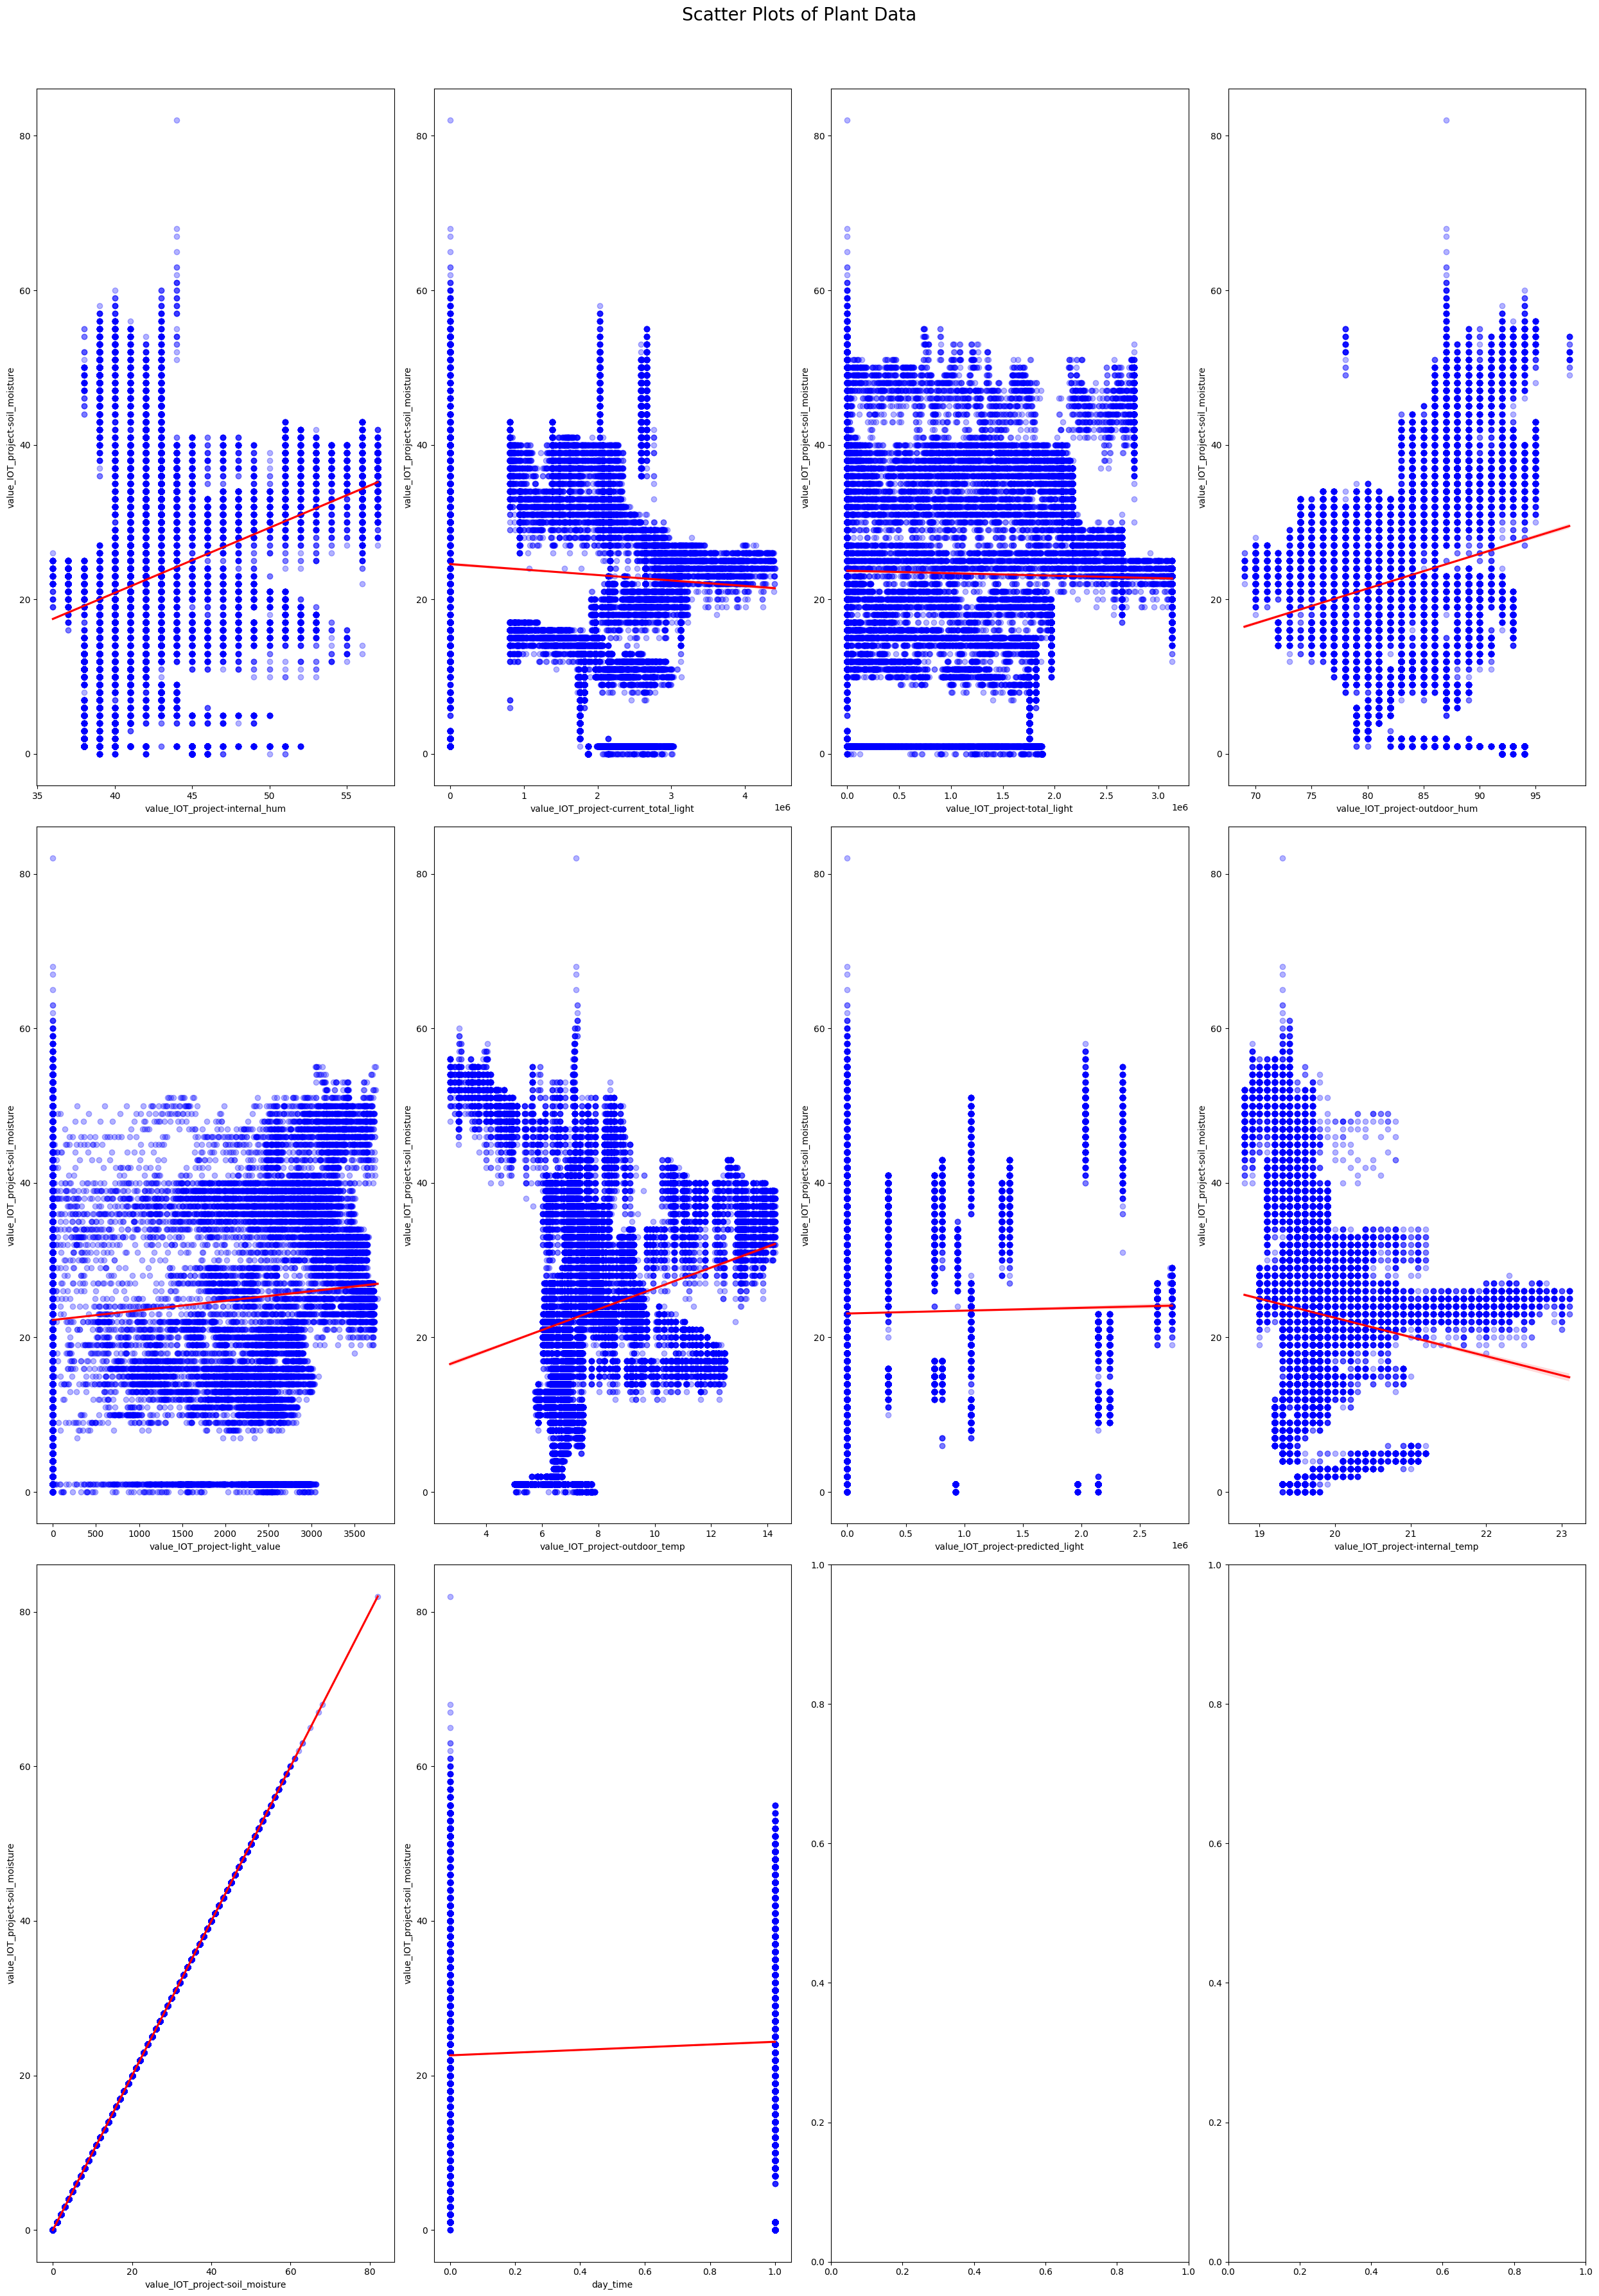

In [295]:
# Create the subplots
fig, axes = plt.subplots(nrows=3, ncols=4) 
fig.set_size_inches(25, 35)
n_cols = 4 # Define the number of columns
for i, column in enumerate(merged_df_copy.columns):
    sns.regplot(x=merged_df_copy[column], y=merged_df_copy['value_IOT_project-soil_moisture'], ax=axes[i//n_cols, i%n_cols], scatter=True, color='blue', scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}) 
fig.suptitle('Scatter Plots of Plant Data', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

In [296]:
# Define the split point (e.g., 70% of the data for training)
split_point = int(len(merged_df_copy) * 0.7)

# Split the data into training and testing sets
train_df = merged_df_copy.iloc[:split_point]
test_df = merged_df_copy.iloc[split_point:]

# Define the features and target variable
X_train = train_df.drop(columns=['value_IOT_project-soil_moisture', 'day_time'])
y_train = train_df['value_IOT_project-soil_moisture']
X_test = test_df.drop(columns=['value_IOT_project-soil_moisture', 'day_time'])
y_test = test_df['value_IOT_project-soil_moisture']

print(f'Training set size: {len(train_df)}')
print(f'Testing set size: {len(test_df)}')

Training set size: 46519
Testing set size: 19938


In [297]:
# Make predictions using the non-linear model
non_linear_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,  # Limit depth
    min_samples_split=10,  # Require a minimum number of samples per split
    random_state=42
)

non_linear_model.fit(X_train, y_train)

# Evaluate the model
y_pred_soil_moisture = non_linear_model.predict(X_train)
mse_soil_moisture_train = mean_squared_error(y_train, y_pred_soil_moisture)
r2_soil_moisture_train = r2_score(y_train, y_pred_soil_moisture)

y_pred_soil_moisture = non_linear_model.predict(X_test)
mse_soil_moisture_test = mean_squared_error(y_test, y_pred_soil_moisture)
r2_soil_moisture_test = r2_score(y_test, y_pred_soil_moisture)

print(f'Train Soil Moisture Prediction Mean Squared Error: {mse_soil_moisture_train}')
print(f'Train Soil Moisture Prediction R^2 Score: {r2_soil_moisture_train}')
print(f'Test Soil Moisture Prediction Mean Squared Error: {mse_soil_moisture_test}')
print(f'Test Soil Moisture Prediction R^2 Score: {r2_soil_moisture_test}')

Train Soil Moisture Prediction Mean Squared Error: 4.272703313529899
Train Soil Moisture Prediction R^2 Score: 0.9643050066230301
Test Soil Moisture Prediction Mean Squared Error: 599.478067739543
Test Soil Moisture Prediction R^2 Score: -11.029132391817047
